<a href="https://colab.research.google.com/github/bobby-he/Neural_Tangent_Kernel/blob/master/notebooks/anaytic_kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/bobby-he/Neural_Tangent_Kernel.git

Cloning into 'Neural_Tangent_Kernel'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 685 (delta 73), reused 5 (delta 2), pack-reused 571
Receiving objects: 100% (685/685), 31.54 MiB | 25.45 MiB/s, done.
Resolving deltas: 100% (413/413), done.


In [0]:
from google.colab import files

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import seaborn as sns
sns.set()
from collections import OrderedDict
import sys

from Neural_Tangent_Kernel.src.NTK_net import *
use_cuda = True if torch.cuda.is_available() else False


In [0]:
#@title This cell contains the data for the example
# to remove

#gamma_data = torch.tensor(np.array([-2.2, -1, 1, 2.2]))
gamma_data = torch.tensor(np.array([-2.2, 0, 1, 2.2]))
n_train = len(gamma_data)
target_data = torch.tensor(np.array([-0.4, -0.2, 0.3, 0.3])).float()
input_data = circle_transform(gamma_data)
if use_cuda:
  input_data = input_data.cuda()
  target_data = target_data.cuda()
gamma_test = torch.tensor(np.linspace(-np.pi, np.pi, 100))
n_test = len(gamma_test)
test_data = circle_transform(gamma_test)
if use_cuda:
  test_data = test_data.cuda()

In [0]:
# Computation of the analytic GP kernel, and NTK, extending https://github.com/widedeepnetworks/widedeepnetworks.git  

class DeepArcCosine(object):

    def __init__(self, input_dim, num_steps,
                 variance=1.0, bias_variance=0., active_dims=None):
        self.input_dim =input_dim
        self.num_steps = num_steps
        self.bias_variance=bias_variance
        self.variance=variance
       
    
    def baseK(self, X, X2):
        inner = torch.matmul(X * self.variance, X2.t())/self.input_dim
        return inner + torch.ones_like(inner) * self.bias_variance
        
    def baseKdiag(self, X):
        inner = torch.sum(self.variance*X**2, 1)/self.input_dim
        return inner + torch.ones_like(inner) * self.bias_variance
        
    def K(self, X, X2):
        # initialisation
        K = self.baseK( X, X2 ) 
        kxdiag  = self.baseKdiag(X)
        kx2diag = self.baseKdiag(X2) 
        
        # iterative computation of the kernel
        for step_index in range(self.num_steps):
            K = self.recurseK( K, kxdiag, kx2diag )
            kxdiag = self.recurseKdiag( kxdiag )
            kx2diag = self.recurseKdiag( kx2diag )

        return K

    def recurseK(self, K, kxdiag, kx2diag):
        norms = torch.sqrt(kxdiag)
        norms_rec = torch.rsqrt(kxdiag)
        norms2 = torch.sqrt(kx2diag)
        norms2_rec = torch.rsqrt(kx2diag)
        
        jitter = 1e-7
        scaled_numerator = K * (1.-jitter)

        cos_theta = scaled_numerator * norms_rec[:,None] *  norms2_rec[None,:]   #elementwise multiplication 
        theta = torch.acos(cos_theta) 
        
        return (self.variance / (2*np.pi)) * (torch.sqrt(kxdiag[:,None] * kx2diag[None,:] - torch.mul(scaled_numerator,scaled_numerator) ) + (np.pi - theta) * scaled_numerator ) + self.bias_variance*torch.ones_like(K)
    
    def NTK(self,X,X2=None):
      
        # initialisation
        if X2 is None:
          X2 = X
        NTK = self.baseK( X, X2 )  # because NTK^1 = K^1
        ntkxdiag  = self.baseKdiag(X)
        ntkx2diag = self.baseKdiag(X2) 
        
        K = self.baseK( X, X2 )
        kxdiag  = self.baseKdiag(X)
        kx2diag = self.baseKdiag(X2) 
        
        # recursion
        for step_index in range(self.num_steps):
          # recursively compute relu kernel
          K_new = self.recurseK( K, kxdiag, kx2diag )
          kxdiag_new = self.recurseKdiag( kxdiag )
          kx2diag_new = self.recurseKdiag( kx2diag )
          NTK = self.recurseNTK( NTK, K,kx2diag,kxdiag, K_new)
          K = K_new
          kxdiag = kxdiag_new
          kx2diag = kx2diag_new
           
        return NTK
      
    def recurseNTK(self, NTK,K,kx2diag,kxdiag, K_new):
        norms = torch.sqrt(kxdiag)
        norms_rec = torch.rsqrt(kxdiag)
        norms2 = torch.sqrt(kx2diag)
        norms2_rec = torch.rsqrt(kx2diag)
        
        jitter = 1e-7
        scaled_numerator = K * (1.-jitter)
                
        cos_theta = scaled_numerator * norms_rec[:,None] *  norms2_rec[None,:]
        theta = torch.acos(cos_theta) 
        return K_new + self.variance *(0.5/np.pi)*NTK*(np.pi - theta)
       
      
    def recurseKdiag(self, Kdiag):
        # angle is zero, hence the diagonal stays the same (if relu is used)        
        return 0.5*self.variance * Kdiag  + self.bias_variance * torch.ones_like(Kdiag)

In [0]:
class NNGP(object):

    def __init__(self, deepArcCosine,X,Y,X_star):
      self.deepArcCosine = deepArcCosine
      self.X = X
      self.Y = Y
      self.X_star = X_star
      self.K = deepArcCosine.K(X,X).cpu().numpy()
      self.K_star = deepArcCosine.K(X_star,X).cpu().numpy()
      self.K_ss = deepArcCosine.K(X_star,X_star).cpu().numpy()
      self.L =  np.linalg.cholesky(self.K+0.00005 * np.eye(X.shape[0]))
      self.n_test = X_star.shape[0]
    
    
    def prior_std(self):
      return np.sqrt(np.diag(self.K_ss))
      
    def posterior_mean(self):
      Lk = np.linalg.solve(self.L, self.K_star.T) 
      mean_star = np.dot(Lk.T, np.linalg.solve(self.L, self.Y.cpu().numpy())).reshape((self.n_test,))
      return mean_star
      
    def posterior_std(self):
      Lk = np.linalg.solve(self.L,self.K_star.T) 
      s2 = np.diag(self.K_ss) - np.sum(Lk**2, axis=0)
      stdv = np.sqrt(s2)
      return(stdv)
      
    def get_K(self):
      return self.K
    
    def get_Kstar(self):
      return self.K_star
    
    def get_Kss(self):
      return self.K_ss

In [0]:
class NTK_analytic_pred(object):

    def __init__(self, deepArcCosine,X,Y,X_star,t,eta,K,K_star,K_ss):
      self.deepArcCosine = deepArcCosine
      self.t=t
      self.eta=eta
      self.X = X
      self.Y = Y
      self.X_star = X_star
      self.K = K
      self.K_star = K_star
      self.K_ss = K_ss
      self.n_test = X_star.shape[0]
      self.NTK_star = deepArcCosine.NTK(X_star,X).cpu().numpy()
      self.NTK_ss = deepArcCosine.NTK(X_star,X_star).cpu().numpy()
      self.NTK = deepArcCosine.NTK(X,X).cpu().numpy()

    def get_NTK_s(self):
      return self.NTK_star
    
    def NTK_mean(self):
      L_NTK = np.linalg.cholesky(self.NTK+0.00005 * np.eye(self.X.shape[0]))
      L_help = np.linalg.solve(L_NTK, self.NTK_star.T)  # 4 x 100
      mat = np.eye(X.shape[0])-scipy.linalg.expm(-self.eta*self.t*self.NTK)
      Y_transf = mat.dot(self.Y.cpu().numpy())
      meanNTK_star = np.matmul(L_help.T, np.linalg.solve(L_NTK, Y_transf)).reshape((self.n_test,))
      return meanNTK_star


    def NTK_std(self):
      inv = np.linalg.inv(self.NTK)
      mat = np.eye(self.X.shape[0])-scipy.linalg.expm(-self.eta*self.t*self.NTK)
      Temp = np.matmul(self.NTK_star,np.matmul(inv,mat))
      A = np.matmul(Temp,self.K_star.T)
      B = np.matmul(inv,np.matmul(mat,self.NTK_star.T))
      s2 = np.diag(self.K_ss)-2*np.diag(A)+np.diag(np.matmul(Temp,np.matmul(self.K,B)))
      stdv_NTK = np.sqrt(s2)
      return stdv_NTK

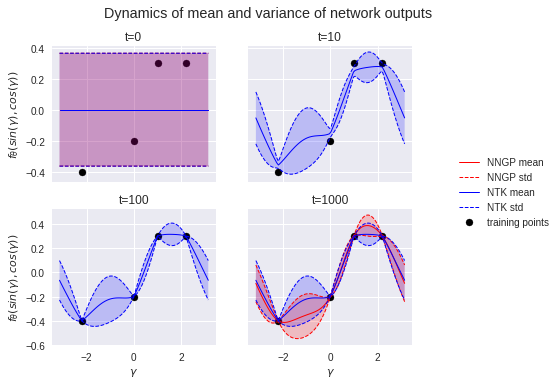

In [24]:
#@title Plot
bias_variance = 0.1*0.1
variance = 1
input_dim = 2
num_hidden_layers = 3
eta = 1

deepArcCosine = DeepArcCosine(input_dim = input_dim, num_steps = num_hidden_layers, variance=variance, bias_variance = bias_variance)

X = input_data
Y = target_data
X_star = test_data

# NNGP prior and posterior
nngp = NNGP(deepArcCosine,X,Y,X_star)
prior_std = nngp.prior_std()
posterior_mean = nngp.posterior_mean()
posterior_std = nngp.posterior_std()

# get the NNGP kernels
K = nngp.get_K()
K_star = nngp.get_Kstar()
K_ss = nngp.get_Kss()

# get NTK at time t 
times = np.array([0,10,100,1000])
NTK_means = np.zeros((4,X_star.shape[0]))
NTK_stds = np.zeros((4,X_star.shape[0]))

for i in range(len(times)):
  myNTK = NTK_analytic_pred(deepArcCosine,X,Y,X_star,times[i],eta,K,K_star,K_ss)
  NTK_means[i] = myNTK.NTK_mean()
  NTK_stds[i] = myNTK.NTK_std()

# plot 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
f.suptitle('Dynamics of mean and variance of network outputs')

ax1.scatter(gamma_data.cpu().numpy(), target_data.cpu().numpy(), color='black',label = 'training points')
ax1.plot(gamma_test.cpu().numpy(), np.zeros(X_star.shape[0]), color='red',
           linestyle='-', alpha = 1,  label = 'NNGP mean', linewidth = 1)
ax1.plot(gamma_test.cpu().numpy(), 1.28*prior_std, color='red',
           linestyle='--', alpha = 1,  label = 'NNGP std', linewidth = 1)
ax1.plot(gamma_test.cpu().numpy(), -1.28*prior_std, color='red',
           linestyle='--', alpha = 1, linewidth = 1)
ax1.plot(gamma_test.cpu().numpy(), NTK_means[0], color='blue',
           linestyle='-', alpha = 1,  label = 'NTK mean', linewidth = 1)
ax1.plot(gamma_test.cpu().numpy(), NTK_means[0]+1.28*NTK_stds[0], color='blue',
           linestyle='--', alpha = 1,  label = 'NTK std', linewidth = 1)
ax1.plot(gamma_test.cpu().numpy(), NTK_means[0]-1.28*NTK_stds[0], color='blue',
           linestyle='--', alpha = 1, linewidth = 1)
ax1.fill_between(gamma_test.cpu().numpy(), 1.28*prior_std, -1.28*prior_std, facecolor='blue', alpha=0.2)
ax1.fill_between(gamma_test.cpu().numpy(), 1.28*prior_std, -1.28*prior_std, facecolor='red', alpha=0.2)
ax1.set_title('t=%i' %times[0])

ax2.scatter(gamma_data.cpu().numpy(), target_data.cpu().numpy(), color='black',label = 'training points')
ax2.plot(gamma_test.cpu().numpy(), NTK_means[1], color='blue',
           linestyle='-', alpha = 1,  label = 'NTK mean', linewidth = 1)
ax2.plot(gamma_test.cpu().numpy(), NTK_means[1]+1.28*NTK_stds[1], color='blue',
           linestyle='--', alpha = 1,  label = 'NTK std', linewidth = 1)
ax2.plot(gamma_test.cpu().numpy(), NTK_means[1]-1.28*NTK_stds[1], color='blue',
           linestyle='--', alpha = 1, linewidth = 1)
ax2.fill_between(gamma_test.cpu().numpy(), NTK_means[1]+1.28*NTK_stds[1], NTK_means[1]-1.28*NTK_stds[1], facecolor='blue', alpha=0.2)
ax2.set_title('t=%i' %times[1])


ax3.scatter(gamma_data.cpu().numpy(), target_data.cpu().numpy(), color='black',label = 'training points')
ax3.plot(gamma_test.cpu().numpy(), NTK_means[2], color='blue',
           linestyle='-', alpha = 1,  label = 'NTK mean', linewidth = 1)
ax3.plot(gamma_test.cpu().numpy(), NTK_means[2]+1.28*NTK_stds[2], color='blue',
           linestyle='--', alpha = 1,  label = 'NTK std', linewidth = 1)
ax3.plot(gamma_test.cpu().numpy(), NTK_means[2]-1.28*NTK_stds[2], color='blue',
           linestyle='--', alpha = 1, linewidth = 1)
ax3.fill_between(gamma_test.cpu().numpy(), NTK_means[2]+1.28*NTK_stds[2], NTK_means[2]-1.28*NTK_stds[2], facecolor='blue', alpha=0.2)
ax3.set_title('t=%i' %times[2])

ax4.scatter(gamma_data.cpu().numpy(), target_data.cpu().numpy(), color='black',label = 'training points')
ax4.plot(gamma_test.cpu().numpy(), posterior_mean, color='red',
           linestyle='-', alpha = 1,  label = 'NNGP mean', linewidth = 1)
ax4.plot(gamma_test.cpu().numpy(), posterior_mean+1.28*posterior_std, color='red',
           linestyle='--', alpha = 1,  label = 'NNGP std', linewidth = 1)
ax4.plot(gamma_test.cpu().numpy(), posterior_mean-1.28*posterior_std, color='red',
           linestyle='--', alpha = 1, linewidth = 1)
ax4.plot(gamma_test.cpu().numpy(), NTK_means[3], color='blue',
           linestyle='-', alpha = 1,  label = 'NTK mean', linewidth = 1)
ax4.plot(gamma_test.cpu().numpy(), NTK_means[3]+1.28*NTK_stds[3], color='blue',
           linestyle='--', alpha = 1,  label = 'NTK std', linewidth = 1)
ax4.plot(gamma_test.cpu().numpy(), NTK_means[3]-1.28*NTK_stds[3], color='blue',
           linestyle='--', alpha = 1, linewidth = 1)
ax4.fill_between(gamma_test.cpu().numpy(), NTK_means[3]+1.28*NTK_stds[3], NTK_means[3]-1.28*NTK_stds[3], facecolor='blue', alpha=0.2)
ax4.fill_between(gamma_test.cpu().numpy(), posterior_mean+1.28*posterior_std, posterior_mean-1.28*posterior_std, facecolor='red', alpha=0.2)
ax4.set_title('t=%i' %times[3])

ax3.set_xlabel('$\gamma$')
ax4.set_xlabel('$\gamma$')
ax1.set_ylabel('$f_{ \\theta}(sin(\gamma),cos(\gamma))$')
ax3.set_ylabel('$f_{ \\theta}(sin(\gamma),cos(\gamma))$')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
f.legend(by_label.values(), by_label.keys(),loc=7)
f.subplots_adjust(right=0.75)  
plt.show()


In [0]:
myNTK = NTK_analytic_pred(deepArcCosine,X,Y,X_star,times[i],eta,K,K_star,K_ss)
NTKs = myNTK.get_NTK_s()

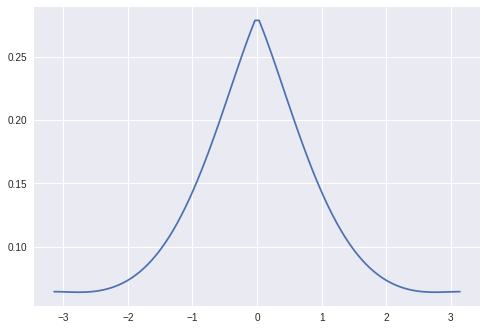

In [26]:
plt.plot(gamma_test.cpu().numpy(),NTKs[:,1])

In [0]:
kernels = np.zeros((20,100))
widths = np.array((500,5000))

for j in range(len(widths)):
  for i in range(10):
    net = FourLayersNet(widths[j]).to("cuda" if use_cuda else "cpu")
    theta_0 = kernel_mats(net, gamma_data, gamma_test, use_cuda=use_cuda, kernels='testvtrain').cpu().numpy()
    kernels[10*j+1]=theta_0[:,1]
    del net
    del theta_0

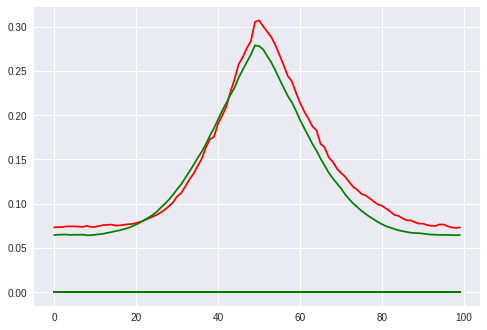

In [31]:
for i in range(10):
  plt.plot(kernels[i],color='red')
  
for i in range(10,20):
  plt.plot(kernels[i],color='green')

In [32]:
kernels[1]

array([0.07322643, 0.07354341, 0.0735428 , 0.07437545, 0.07438075,
       0.07437114, 0.07412166, 0.07380266, 0.07503142, 0.07369568,
       0.07380362, 0.07491988, 0.07583267, 0.07613003, 0.07636136,
       0.07536892, 0.07554517, 0.07619645, 0.07674929, 0.07715284,
       0.07816688, 0.07945434, 0.08126171, 0.08340677, 0.08530951,
       0.08727355, 0.09011684, 0.09329753, 0.09713376, 0.10144808,
       0.10815006, 0.1120766 , 0.1194127 , 0.12744689, 0.13379461,
       0.14259805, 0.15060635, 0.16333267, 0.17273955, 0.17568658,
       0.19062035, 0.19942529, 0.20968558, 0.22607189, 0.24038272,
       0.25750607, 0.26549414, 0.27566707, 0.28376344, 0.30544302,
       0.30714566, 0.3003433 , 0.29435176, 0.28819877, 0.27902034,
       0.26788127, 0.25642267, 0.24441953, 0.23828787, 0.22549637,
       0.2140384 , 0.20437866, 0.19650047, 0.18750398, 0.18296963,
       0.16770904, 0.16353308, 0.15236129, 0.147312  , 0.13968177,
       0.13468906, 0.13044977, 0.12448291, 0.11880334, 0.11550